In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import logging
import pprint
import os
import re

import warnings
warnings.filterwarnings("ignore")

from music21 import converter, corpus, instrument, midi, note, chord, pitch, roman, stream
import mido
from mido import Message, MidiFile, MidiTrack

### 1. Convert note events to timeseries [t,note,vel]
eg. [[0,'C3',23],[2,'D3',56],[35,'D#3',55],[102,'C3',12]]


In [2]:
# returning all note on events from file in the form [[t,note,vel],[t,note,vel],[t,note,vel],...]
def midi_to_timeseries(midiPath):
    
    time_notes = []
#     midiFile = converter.parse(midiPath)
    uniqueTypes = [128,144,176]
    with open(midiPath) as midi_events:
        for line in midi_events:
            processedLine = line.split(" ")
    
            processedLine[0] = int(processedLine[0])
            processedLine[1] = int(processedLine[1], 16)

            if processedLine[1] not in uniqueTypes:
                print("unexpected event type got! ", processedLine[1])

            #    MIDI EVENT TYPES
            #    0x80 (hex)      128 (decimal)    Note Off
            #    0x90 (hex)      144 (decimal)    Note On
            #    0xB0 (hex)      176 (decimal)    Continuous Controller

            # processedLine[2] is note
            processedLine[2] = int(processedLine[2], 16)

            # processedLine[3] is velocity
            processedLine[3] = int(processedLine[3],16)

            if processedLine[1] == 144:
                time_notes.append([processedLine[0], processedLine[2], processedLine[3]])
                
    return time_notes



In [3]:
# generate dataframe of snippets
midiPath = '/Users/snehashah/Desktop/Stagecast/midi-recordings/ladispute.txt'
time_notes = midi_to_timeseries(midiPath)
#plot time_notes?

### STEP 2: Define a simplest similarity metric 

Asumptions & notes: 

-> minimal mistakes (wrong note gets 0 score)

-> similar spped (time is penalized by time diff)

-> time error as absolute not percentage

-> multiple notes can be played together (so not compared by order)

-> done wrt time not note events (timeseries) is this best way to represent notes? maybe as buckets?

-> ignoring vel

-> discriminate between octaves

-> Idea: for speed change. take any similar note set and scale time by total time to play the set.

-> traversing note by note  for targets (not ms by ms)

-> Need to check different values for:
    
    penalty for time change/ min distance/ wrt penalty for wrong note
    
    threshold
    
    min matches

In [114]:
def musical_similarity(tf1, tf2):
    sequence1 = []
    first = tf1[0]
    for el in tf1:
        sequence1.append([el[0]-first[0],el[1]])
        
    sequence2 = []
    first = tf2[0]
    for el in tf2:
        sequence2.append([el[0]-first[0],el[1]])
        
    score = []
    for event1 in range(len(sequence1)):
        for event2 in range(len(sequence2)):
            s = note_similarity(sequence1[event1],sequence2[event2])
#             print(sequence1[event1],sequence2[event2])
            if s != 0:
                score.append(s)
                sequence1[event1] = []
                sequence2[event2] = []
                break
                
    for i in range(len(sequence1) + len(sequence2) - (2*len(score))):
        score.append(0)
        
#     print(sequence1)
#     print(sequence2)
#     print(score)
    return np.mean(score)
        
        
def note_similarity(note1,note2):
    # score is linear with time difference between notes
    
#     strictness = 0.2 # note within 10% time difference
    min_dist = 300 # 300ms is arbitrary audible difference
    
    if (not note1) or (not note2):
        return 0
    if note1 == note2: # exact match!
        return 1
    if note1[1] != note2[1]: # different notes
        return 0
    
    # check if acceptable match
    time_diff = abs(note1[0] - note2[0])
#     print(time_diff)
    if  time_diff < min_dist:
        return 1 - time_diff/min_dist
    else:
        return 0
    
def get_note(i):
    # convert integer to note
    notes = ['C','C#/Db','D','D#/Eb','E','F','F#/Gb','G','G#/Ab','A','A#/Bb','B']
    return notes[i%12] + str(i//12 - 1)

def get_int(note):
    # convert integer to note
    temp = re.compile("([a-zA-Z]+)([0-9]+)")
    note = temp.match(note).groups()
    notes = {'C':0,'C#/Db':1,'C#':1,'Db':1,'D':2,'D#/Eb':3,'D#':3,'Eb':3,'E':4,'F':5,'F#/Gb':6,'F#':6,'Gb':6,'G':7,'G#/Ab':8,'Ab':8,'G#':8,'A':9,'A#/Bb':10,'A#':10,'Bb':10,'B':11}
    return notes[note[0]] + 12*(int(note[1])+1)

def calculate_similarity(source, targets, i):
    matches = []
    count = 0
    for target in targets:
        score = musical_similarity(source, target)
        if score:
            matches.append([i, target[0][0], score])
        count += 1
        
    return matches

def get_source_targets_index(snips, start_index, min_notes, max_notes, min_time, offset=0):
    for length in range(offset, max_notes-min_notes):
        if snips[length][start_index-min_notes-length][-1][0]-snips[length][start_index-min_notes-length][0][0]>=min_time:
            source = snips[length][start_index-min_notes]
            targets = snips[length][0:start_index+1-min_notes]
            return source, targets
        
    print("Error: Trying to access snippet length > max_notes")
    return None, None

def get_source_targets(snips, start_time, min_notes, max_notes, min_time, offset=0):
    for i in range(len(snips[0])):
        if snips[0][i][0][0] >= start_time:
            start_index = i
            break
    else:
        print("Error: Start time too large")
        return None, None
    
    if start_index<3:
        return None, None
    
    return get_source_targets_index(snips, start_index, min_notes, max_notes, min_time, offset)
    

In [59]:
# Zulip example to test similarity score
tf1 = [[-17,60],[-100,62],[-101,64],[-300,60]]
tf2 = [[-20,60],[-50,61],[-101,64],[-102,62],[-307,60]]

musical_similarity(tf1,tf2)

0.7946666666666666

In [115]:
# Snippet note length = 1
minNotes = 4
maxNotes = 30 # max length of snippet to be calculated
minTime = 500 # min time in ms

# generate dataframe of snippets
snips = []
midiPath = '/Users/snehashah/Desktop/Stagecast/midi-recordings/ladispute.txt'
notes = midi_to_timeseries(midiPath)

for j in range(minNotes, maxNotes + 1):
    ind = j - minNotes
    snips.append([])
    for i in range(len(notes)+1-j):
        snip = notes[i: i+j]
        snips[ind].append(snip)


In [67]:
notes[-1][0]

729285

In [107]:
# calculating similarity

# multiple matches
# sims_arr = []
# for i in range(minTime, snips[0][-1][0][0], 500):
# #     print("\r",end="")
# #     print("i:",i)
#     # only calculate on historical timestamps
#     source, targets = get_source_targets(snips, i, minNotes, maxNotes, minTime)
#     if not source:
#         continue
#     sim = calculate_similarity(source, targets, i)
#     for match in sim:
#         sims_arr.append(match)
        
# for a single match
sims_arr = []
for i in range(minTime, notes[-1][0], 500):
    print("\r",end="")
    print("i:",i,end="   ")
    # only calculate on historical timestamps
    offset = 0
    count = 16 # count number of relevant matches
    min_matches = 3
    while count > min_matches:
        source, targets = get_source_targets(snips, i, minNotes, maxNotes, minTime,offset)
        if not source:
            break
        sim = calculate_similarity(source, targets, i)
        count = 0
        for match in sim:
            if match[2] > 0.7:
                count += 1
#         print("\b",end="")
#         print(len(targets))
        offset += 2
        
    if count < 2:
        print("Only 1 match found! (self)")
    if source:
        for match in sim:
            sims_arr.append(match)


i: 196000   Error: Number of notes in 500ms exceeded max_notes
i: 223000   Error: Number of notes in 500ms exceeded max_notes
i: 225000   Error: Number of notes in 500ms exceeded max_notes
i: 225500   Error: Number of notes in 500ms exceeded max_notes
i: 231500   Error: Number of notes in 500ms exceeded max_notes
i: 238500   Error: Number of notes in 500ms exceeded max_notes
i: 239000   Error: Number of notes in 500ms exceeded max_notes
i: 243000   Error: Number of notes in 500ms exceeded max_notes
i: 257500   Error: Number of notes in 500ms exceeded max_notes
i: 268500   Error: Number of notes in 500ms exceeded max_notes
i: 269000   Error: Number of notes in 500ms exceeded max_notes
i: 271500   Error: Number of notes in 500ms exceeded max_notes
i: 272000   Error: Number of notes in 500ms exceeded max_notes
i: 273500   Error: Number of notes in 500ms exceeded max_notes
i: 290000   Error: Number of notes in 500ms exceeded max_notes
i: 329000   Error: Number of notes in 500ms exceeded ma

In [112]:
# choosing only significant scores and storing the new data in sims_plot

sims_arr = np.array(sims_arr)
sims_bool = sims_arr>0.7 # considering a match if score greater than a threshold
sims_plot = sims_arr * sims_bool
sims_plot

array([[1.00000e+03, 2.51000e+02, 1.00000e+00],
       [1.50000e+03, 2.51000e+02, 0.00000e+00],
       [1.50000e+03, 2.54000e+02, 1.00000e+00],
       ...,
       [7.27500e+05, 7.22323e+05, 0.00000e+00],
       [7.27500e+05, 7.22409e+05, 0.00000e+00],
       [7.27500e+05, 7.25642e+05, 1.00000e+00]])

<AxesSubplot:title={'center':'Min Snippet Length=4 notes, Min matches=3'}, xlabel='source_timestamp', ylabel='target_timestamp'>

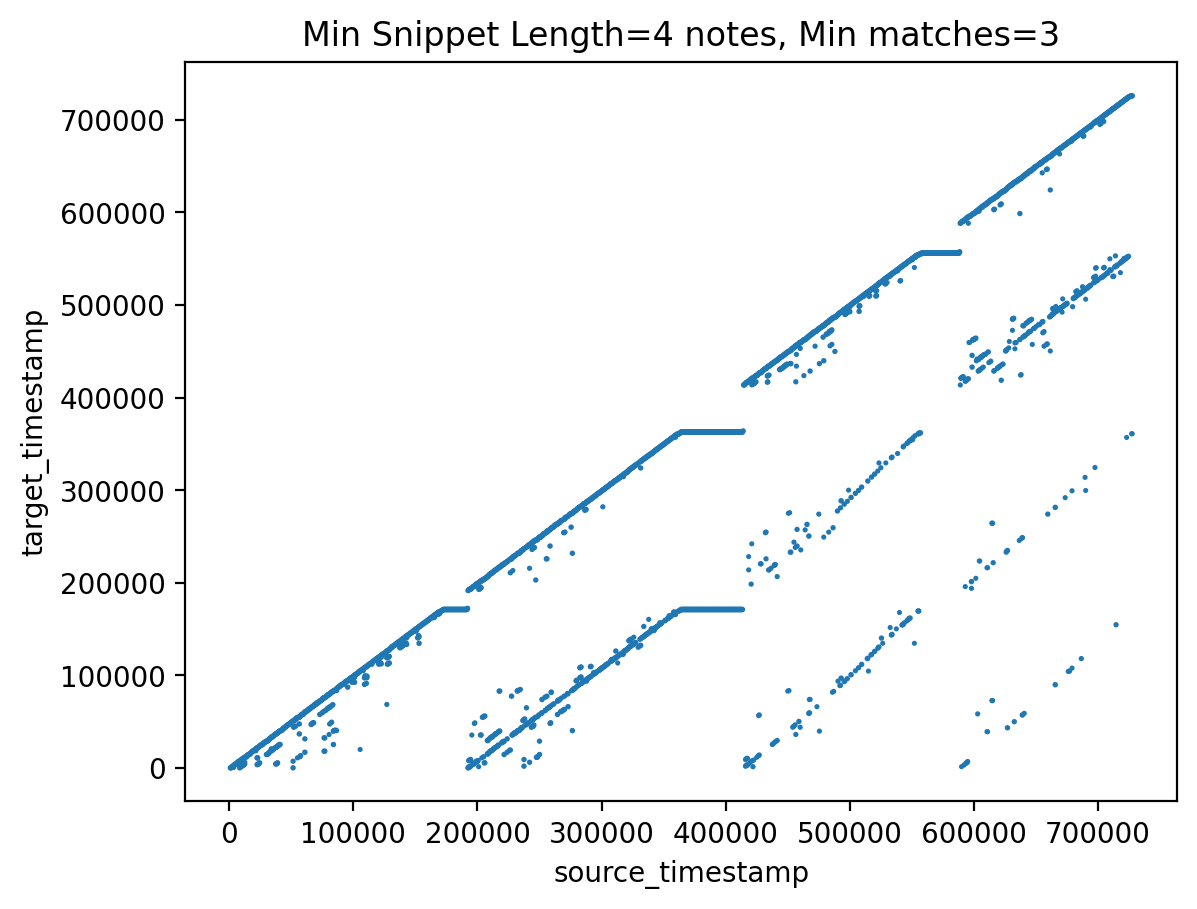

In [122]:
simsDF = pd.DataFrame(data=sims_plot, columns=['source_timestamp', 'target_timestamp','score'])
title = "Min Snippet Length=" + str(minNotes) + " notes, Min matches=" + str(min_matches)
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)

In [ ]:
# earlier approach - calculate score as sum of scores from minNotes to maxNotes
# too sow for time length 2d array (conversions between types and traveersing)

minNotes = 4
maxNotes = 4
history = 'full'

# generate dataframe of snippets
snips = []
midiPath = '/Users/snehashah/Desktop/Stagecast/midi-recordings/ladispute.txt'
notes = midi_to_timeseries(midiPath)

for j in range(minNotes, maxNotes+1):
    ind = j - minNotes
    snips.append([])
    for i in range(len(notes)+1-j):
        snip = notes[i: i+j]
        snips[ind].append(snip)
        
sims = np.zeros((notes[-1][0],notes[-1][0])) # only for diff minNotes and maxNotes
sims_arr = []
# print(sims.shape)
for i in range(len(notes)):
    print("\r",end="")
    print("i:",i,end=", j:       ")
    for j in range(minNotes, maxNotes+1): # j is length of notes
        if i-j<0:
            break
#         print("\b",end="")
#         print("\b",end="")
#         print(j,end="")
        ind = j - minNotes
        # only calculate on historical timestamps
        source = snips[ind][i-j]
        targets = snips[ind][0:i+1-j]
        sim = calculate_similarity(source, targets)
        # create a single df
        for match in sim:
            sims[match[0],match[1]] += match[2] # only for diff minNotes and maxNotes
            sims_arr.append(match)

# Find a way to skip this step - very slow for time vs time axis!!
if minNotes != maxNotes:
    sims_arr = []
    for row in range(len(sims)):
        for col in range(len(sims[0])):
            if sims[row][col] != 0:
                sims_arr.append([row,col,sims[row][col]])
                
sims_arr = np.array(sims_arr)
sims_bool = sims_arr>0.7
sims_plot = sims_arr * sims_bool
sims_plot

simsDF = pd.DataFrame(data=sims_plot, columns=['source_timestamp', 'target_timestamp','score'])
# simsTimeDF = pd.DataFrame(data=simsTimeArr, columns=["source_noteIDX", "target_noteIDX", "score", "source_timestamp", "target_timestamp"])

title = "MIDI Note Vectorization, Snippet Length=" + str(minNotes) + ", Similarity=musical_similarity" 
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)

'''Maximum plot for above''' 
sims_max = []
for row in range(11,len(sims)):
    maxi = np.argmax(sims[row][0:row-10])
    sims_max.append([row,maxi,sims[row][maxi]])
simsDF = pd.DataFrame(data=sims_max, columns=['source_timestamp', 'target_timestamp', 'score'])
title = "MIDI Note Vectorization, Snippet Length=" + str(minNotes) + ", Similarity=musical_similarity"
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)